#### Notebook to compare the significant independent QTL signals by day

In [1]:
!date

Mon Aug 16 12:16:40 EDT 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
import os

In [3]:
# parameters
cohort = 'foundin'

# naming
# cohort_build = f'{cohort}.{day}'

# directories
wrk_dir = f'/home/gibbsr/foundin/caqtl'
tensorqtl_dir = f'{wrk_dir}/tensorqtl'
results_dir = f'{wrk_dir}/results'

# input files

# out files
indep_results_file = f'{results_dir}/{cohort}.cis.csv'

# constants
days = ['da0', 'da25', 'da65']
autosomes = [str(x) for x in list(range(1,23))]
cpu_count = len(os.sched_getaffinity(0))

#### load the results

In [4]:
# load the independent results
indep_df = None
for day in days:
    cohort_build = f'{cohort}.{day}'
    cis_indep_file = f'{results_dir}/{cohort_build}.cis.indep.csv'
    day_df = pd.read_csv(cis_indep_file)
    feature_cnt = len(day_df['phenotype_id'].unique())
    print(f'day {day} shape is {day_df.shape} for {feature_cnt} features')
    day_df['day'] = day
    indep_df = pd.concat([indep_df, day_df])
    print(f'after day {day} total shape {indep_df.shape}')

day da0 shape is (338, 18) for 337 features
after day da0 total shape (338, 19)
day da25 shape is (509, 18) for 504 features
after day da25 total shape (847, 19)
day da65 shape is (182, 18) for 181 features
after day da65 total shape (1029, 19)


In [5]:
# load the full cis results keep if in indep results
cis_df = None
for day in days:
    cohort_build = f'{cohort}.{day}'
    cis_file = f'{tensorqtl_dir}/{cohort_build}.cis.map.csv'
    day_df = pd.read_csv(cis_file)
    day_indep = indep_df.loc[indep_df['day'] == day]
    # subsut the day top by the day independent sig
    day_df = day_df.loc[day_df['phenotype_id'].isin(day_indep['phenotype_id'])]
    feature_cnt = len(day_df['phenotype_id'].unique())
    print(f'day {day} shape is {day_df.shape} for {feature_cnt} features')
    day_df['day'] = day
    cis_df = pd.concat([cis_df, day_df])
    print(f'after day {day} total shape {cis_df.shape}')

day da0 shape is (337, 17) for 337 features
after day da0 total shape (337, 18)
day da25 shape is (504, 17) for 504 features
after day da25 total shape (841, 18)
day da65 shape is (181, 17) for 181 features
after day da65 total shape (1022, 18)


In [6]:
print(indep_df.shape)
display(indep_df.sample(5))

(1029, 19)


,Unnamed: 0,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank,day
348,348,chr2_88094780_88095864,2500,1.366731,174.25133,49.040634,1.348148e-07,rs2970906,-365,48,58,0.315217,8.185884e-13,0.120875,0.014498,0.0001,3.881787e-07,1,da25
440,440,chr13_57786884_57788065,5264,1.037632,269.28110,79.277660,1.523133e-10,rs9527684,-85880,65,92,0.500000,8.806565e-12,0.164401,0.020976,0.0001,2.127555e-08,1,da25
117,117,chr11_18668248_18669053,6373,1.648880,684.76215,49.253117,1.789208e-08,rs11024755,651,53,69,0.387640,6.390761e-14,0.113108,0.012673,0.0001,5.369833e-09,1,da65
261,261,chr10_40760012_40760764,289,0.966801,17.34174,47.910583,2.494091e-08,rs80287445,966710,16,19,0.103261,1.905781e-14,-0.204592,0.022425,0.0001,7.125642e-07,1,da25
284,284,chr15_33995880_33996513,7441,1.005713,162.49103,34.923820,4.251523e-07,rs12913747,-1021,38,46,0.250000,3.578971e-16,0.144522,0.014521,0.0001,6.524412e-05,1,da25


#### make a key for the variant/pheno pair

In [7]:
indep_df['cispair'] = indep_df['phenotype_id'] + ':' + indep_df['variant_id']
print(indep_df.shape)
display(indep_df.sample(5))

(1029, 20)


,Unnamed: 0,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank,day,cispair
387,387,chr10_40400088_40400985,234,0.948575,20.404175,50.299294,8.133690e-07,rs879108082,-998144,16,19,0.103261,3.809207e-11,-0.179654,0.023869,0.0003,2.981026e-05,1,da25,chr10_40400088_40400985:rs879108082
163,163,chr12_59548696_59549720,6404,0.947224,79.966194,36.762870,2.733401e-07,rs7975803,-34040,30,34,0.180851,3.243962e-16,-0.141803,0.014284,0.0001,3.932990e-05,1,da0,chr12_59548696_59549720:rs7975803
86,86,chr1_25266639_25268457,4795,0.799768,141.109390,43.390740,3.681434e-09,rs72660908,-9520,61,76,0.404255,7.153621e-18,-0.131936,0.012310,0.0001,1.010582e-05,1,da0,chr1_25266639_25268457:rs72660908
74,74,chr12_131646061_131647227,7342,1.496631,246.773820,38.585503,2.878922e-06,rs10902428,32722,57,69,0.367021,4.128626e-13,-0.113091,0.013382,0.0001,1.464739e-05,1,da0,chr12_131646061_131647227:rs10902428
77,77,chr2_177799636_177800247,5623,1.049246,390.957000,86.403580,2.878860e-09,rs71423507,33004,24,25,0.132979,8.859953e-10,-0.159916,0.023405,0.0001,5.611130e-07,1,da0,chr2_177799636_177800247:rs71423507


In [8]:
indep_df['cispair'].value_counts().value_counts()

1    769
2    106
3     16
Name: cispair, dtype: int64

In [9]:
indep_df['day'].value_counts()

da25    509
da0     338
da65    182
Name: day, dtype: int64

In [10]:
len(indep_df['cispair'].unique())

891

#### what is the max p-value in the independent signals

In [11]:
max_pvalue = indep_df['pval_nominal'].max()
print(f'max nominal pvalue {max_pvalue}')

cis_max_pvalue = cis_df['pval_nominal'].max()
print(f'max cis top nominal pvalue {cis_max_pvalue}')

max nominal pvalue 5.293817580715961e-05
max cis top nominal pvalue 5.293817580715961e-05


#### now that all the cispairs of interest are known get complete data for these

In [12]:
def load_missing_qtl_results(find_items, in_file, day):
    qtl_df = dd.read_parquet(in_file).compute()
    qtl_df['cispair'] = qtl_df['phenotype_id'] + ':' + qtl_df['variant_id']
    found_df = qtl_df.loc[qtl_df['cispair'].isin(find_items)].copy()
    found_df['day'] = day
    return found_df

In [13]:
%%time

fs_list = []
lm_results = []
with concurrent.futures.ThreadPoolExecutor() as tpe:
    for day in days:
        cohort_build = f'{cohort}.{day}'
        for chrom in autosomes:
            this_result_file = f'{tensorqtl_dir}/{cohort_build}.*.cis_qtl_pairs.chr{chrom}.parquet'
            fs_list.append(tpe.submit(load_missing_qtl_results, indep_df['cispair'], 
                                      this_result_file, day))
for future in concurrent.futures.as_completed(fs_list):
    lm_results.append(future.result()) 
    
# the above requires quite a bit of memory so if instance doesn't have enough
# load the chromosomes serially instead, lot more time
# results_df = None
# for day in days:
#     cohort_build = f'{cohort}.{day}'
#     for chrom in autosomes:
#         this_file_frmt = f'{tensorqtl_dir}/{cohort_build}.*.cis_qtl_pairs.chr{chrom}.parquet'
#         this_df = load_missing_qtl_results(cis_df['cispair'], this_file_frmt, day)
#         results_df = pd.concat([results_df, this_df])

CPU times: user 39min 6s, sys: 16min 34s, total: 55min 41s
Wall time: 35min 9s


In [14]:
# combine the read results
results_df = pd.concat(lm_results)
print(results_df.shape)
# display(results_df.sample(10))

(2642, 11)


In [15]:
results_df['cispair'].value_counts().value_counts()

3    868
2     15
1      8
Name: cispair, dtype: int64

In [16]:
results_df['day'].value_counts()

da0     889
da25    882
da65    871
Name: day, dtype: int64

In [17]:
results_df['log10_pvalue'] = np.log10(results_df['pval_nominal'])*-1
results_df['score'] = results_df['slope']/results_df['slope_se']
results_df['score_abs'] = np.abs(results_df['score'])
results_df['is_sig'] = 0
results_df.loc[results_df['pval_nominal'] < max_pvalue, 'is_sig'] = 1

In [18]:
results_df.sample(5)

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,day,log10_pvalue,score,score_abs,is_sig
7810981,chr1_86419390_86419764,rs7415758,10880,0.280899,42,50,1.054838e-12,0.116187,0.013949,chr1_86419390_86419764:rs7415758,da65,11.976814,8.329712,8.329712,1
549891,chr17_45500945_45502221,rs62062287,518230,0.275281,42,49,4.271015e-06,-0.096762,0.019718,chr17_45500945_45502221:rs62062287,da65,5.369469,-4.907233,4.907233,1
2846399,chr19_870553_874214,rs1651895,-4535,0.271739,42,50,6.429671e-11,0.107933,0.014556,chr19_870553_874214:rs1651895,da25,10.191811,7.415148,7.415148,1
20072974,chr2_234544865_234545649,rs6739547,617,0.308989,43,55,3.899523e-05,-0.087823,0.020258,chr2_234544865_234545649:rs6739547,da65,4.408988,-4.335154,4.335154,1
2970492,chr17_51439068_51440181,rs7212610,737,0.393258,57,70,6.358736e-07,0.080300,0.014942,chr17_51439068_51440181:rs7212610,da65,6.196629,5.374198,5.374198,1


In [19]:
results_df['is_sig'].value_counts()

1    2038
0     604
Name: is_sig, dtype: int64

#### save the combined results

In [20]:
results_df.to_csv(indep_results_file, index=False)

In [21]:
temp = results_df.groupby(['cispair'])['is_sig'].agg('sum')
display(results_df.loc[results_df['is_sig'] == 0].head())
display(temp.value_counts())

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,day,log10_pvalue,score,score_abs,is_sig
12153070,chr11_19509193_19509832,rs2129538,284,0.335106,51,63,0.634998,0.007840,0.016462,chr11_19509193_19509832:rs2129538,da0,0.197228,0.476289,0.476289,0
4286767,chr11_130611832_130612822,rs61915783,-4400,0.430851,60,81,0.900204,-0.002054,0.016331,chr11_130611832_130612822:rs61915783,da0,0.045659,-0.125750,0.125750,0
4619514,chr11_83640004_83642261,rs12275022,1553,0.260638,43,49,0.746256,-0.005984,0.018437,chr11_83640004_83642261:rs12275022,da0,0.127112,-0.324553,0.324553,0
8039784,chr11_102746485_102747569,rs7478816,1856,0.122340,21,23,0.001245,0.074289,0.022300,chr11_102746485_102747569:rs7478816,da0,2.904706,3.331374,3.331374,0
7428116,chr11_107247219_107248252,rs1844745,-6024,0.500000,67,94,0.319369,-0.013867,0.013851,chr11_107247219_107248252:rs1844745,da0,0.495707,-1.001173,1.001173,0


3    476
1    216
2    197
0      2
Name: is_sig, dtype: int64

In [22]:
temp[temp == 0].head()

cispair
chr13_17304015_17305647:rs1447103670    0
chr4_186432329_186436697:rs11132395     0
Name: is_sig, dtype: int64

In [23]:
display(results_df.loc[results_df['cispair'] == 'chr13_17304015_17305647:rs1447103670'])

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,day,log10_pvalue,score,score_abs,is_sig
915476,chr13_17304015_17305647,rs1447103670,923972,0.016854,2,3,0.065174,0.122292,0.065478,chr13_17304015_17305647:rs1447103670,da65,1.185923,1.867674,1.867674,0
8105227,chr13_17304015_17305647,rs1447103670,923972,0.015957,2,3,0.000053,0.190493,0.044918,chr13_17304015_17305647:rs1447103670,da0,4.276231,4.240941,4.240941,0
6296181,chr13_17304015_17305647,rs1447103670,923972,0.016304,2,3,0.666972,0.021956,0.050855,chr13_17304015_17305647:rs1447103670,da25,0.175892,0.431728,0.431728,0


In [24]:
display(results_df.loc[results_df['cispair'] == 'chr4_186432329_186436697:rs11132395'])

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,day,log10_pvalue,score,score_abs,is_sig
5667148,chr4_186432329_186436697,rs11132395,6122,0.152174,26,28,0.122459,-0.039072,0.025059,chr4_186432329_186436697:rs11132395,da25,0.912008,-1.559197,1.559197,0
14312683,chr4_186432329_186436697,rs11132395,6122,0.151685,25,27,0.007477,-0.071426,0.026079,chr4_186432329_186436697:rs11132395,da65,2.126269,-2.738891,2.738891,0
3186778,chr4_186432329_186436697,rs11132395,6122,0.154255,27,29,0.042951,-0.047664,0.023221,chr4_186432329_186436697:rs11132395,da0,1.367025,-2.052606,2.052606,0


In [25]:
results_df.groupby(['cispair'])['is_sig'].agg('sum').value_counts()

3    476
1    216
2    197
0      2
Name: is_sig, dtype: int64

#### for the stuff that isn't in largest powered group any visit standout

In [26]:
results_df.loc[results_df['day'] != 0]['day'].value_counts()

da0     889
da25    882
da65    871
Name: day, dtype: int64

In [27]:
results_df.loc[results_df['day'] != 0].groupby(['cispair'])['is_sig'].agg('sum').value_counts()

3    476
1    216
2    197
0      2
Name: is_sig, dtype: int64

#### annotate direction of effect for plotting

In [28]:
results_df['Direction'] = np.where(results_df['slope'] > 0, 
                                         'Increase', 'Descrease')
display(results_df.sample(5))

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,day,log10_pvalue,score,score_abs,is_sig,Direction
2673155,chr8_91180084_91180811,rs11780533,-10842,0.375000,58,69,3.153406e-01,-0.019211,0.019026,chr8_91180084_91180811:rs11780533,da25,0.501220,-1.009711,1.009711,0,Descrease
8447961,chr2_88169724_88171577,rs6547757,527,0.230337,40,41,7.352761e-11,-0.162668,0.021923,chr2_88169724_88171577:rs6547757,da65,10.133550,-7.419974,7.419974,1,Descrease
5684530,chr11_107916387_107917551,rs61906917,5108,0.250000,38,47,9.892609e-26,-0.176452,0.012066,chr11_107916387_107917551:rs61906917,da0,25.004689,-14.623684,14.623684,1,Descrease
11165072,chr5_90667665_90668761,rs6452903,19239,0.340426,49,64,3.251241e-11,0.105562,0.014004,chr5_90667665_90668761:rs6452903,da0,10.487951,7.538161,7.538161,1,Increase
2274051,chr1_117612547_117613857,rs893230,-3323,0.239130,39,44,5.423572e-10,-0.170257,0.024475,chr1_117612547_117613857:rs893230,da25,9.265715,-6.956451,6.956451,1,Descrease


#### do some quick plotting

In [29]:
# for seaborn lm plot the day needs to be numeric for ordinal interpret
results_df['daynum'] = results_df['day'].str.replace('da','').astype('int32')

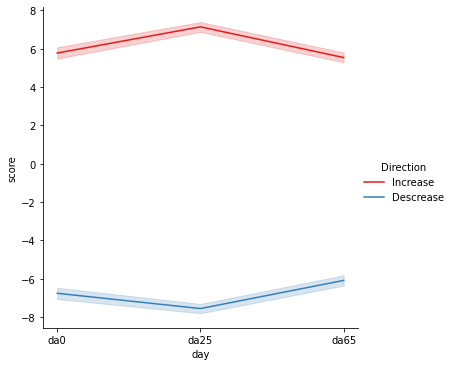

In [30]:
sns.relplot(x='day', y='score', kind='line', hue='Direction',
            data=results_df, palette='Set1')

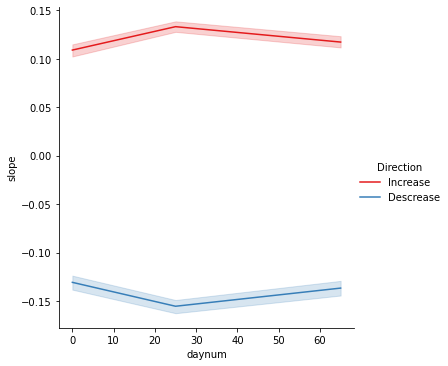

In [31]:
sns.relplot(x='daynum', y='slope', kind='line', hue='Direction',
            data=results_df, palette='Set1')

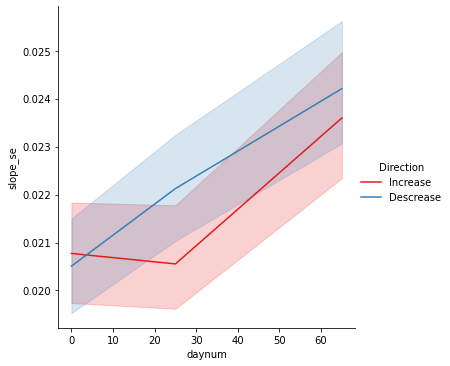

In [32]:
sns.relplot(x='daynum', y='slope_se', kind='line', hue='Direction',
            data=results_df, palette='Set1')

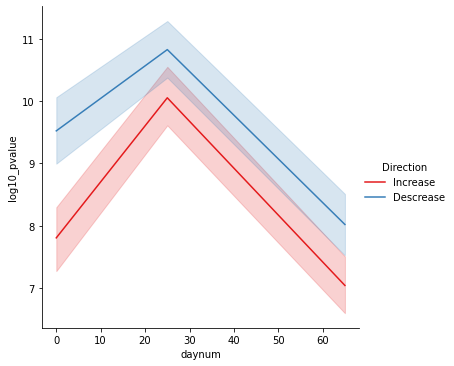

In [33]:
sns.relplot(x='daynum', y='log10_pvalue', kind='line', hue='Direction',
            data=results_df, palette='Set1')

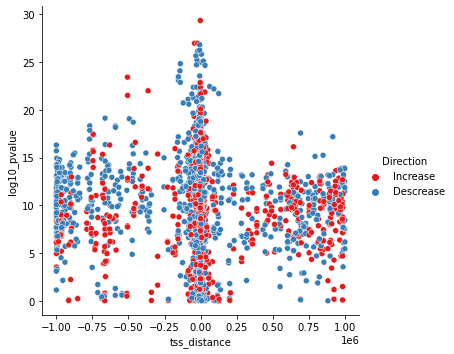

In [34]:
sns.relplot(x='tss_distance', y='log10_pvalue',hue='Direction',
            data=results_df, palette='Set1')

<AxesSubplot:xlabel='tss_distance', ylabel='log10_pvalue'>

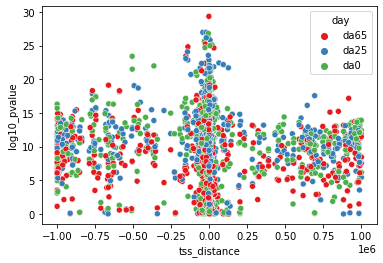

In [35]:
sns.scatterplot(x='tss_distance', y='log10_pvalue', hue='day',
                data=results_df.sample(frac=1), palette='Set1')

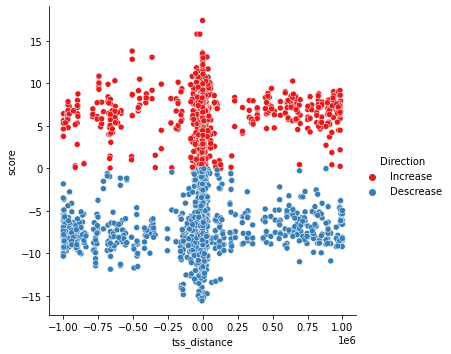

In [36]:
sns.relplot(x='tss_distance', y='score',hue='Direction',
            data=results_df, palette='Set1')

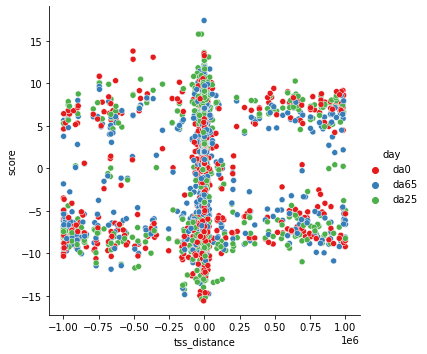

In [37]:
sns.relplot(x='tss_distance', y='score',hue='day',
            data=results_df.sample(frac=1), palette='Set1')

#### format data for ternary plots

In [38]:
da0 = results_df.loc[results_df['day'] == 'da0'].sort_values(by=['cispair'])
da25 = results_df.loc[results_df['day'] == 'da25'].sort_values(by=['cispair'])
da65 = results_df.loc[results_df['day'] == 'da65'].sort_values(by=['cispair'])

In [39]:
all_df = da0.merge(da25, how='left', left_on='cispair', right_on='cispair')
all_df = all_df.merge(da65, how='left', left_on='cispair', right_on='cispair')
display(all_df.head())

,phenotype_id_x,variant_id_x,tss_distance_x,af_x,ma_samples_x,ma_count_x,pval_nominal_x,slope_x,slope_se_x,cispair,...,pval_nominal,slope,slope_se,day,log10_pvalue,score,score_abs,is_sig,Direction,daynum
0,chr10_114874606_114875613,rs749649,7634,0.276596,46,52,4.558437e-01,-0.013814,0.018446,chr10_114874606_114875613:rs749649,...,4.800891e-05,-0.079233,0.018516,da65,4.318678,-4.279280,4.279280,1.0,Descrease,65.0
1,chr10_115586808_115587725,rs34498532,-48334,0.473404,68,89,3.996912e-13,0.113750,0.013450,chr10_115586808_115587725:rs34498532,...,6.156404e-01,0.011964,0.023746,da65,0.210673,0.503850,0.503850,0.0,Increase,65.0
2,chr10_128464065_128465009,rs4750701,7145,0.356383,57,67,3.523497e-12,0.100663,0.012576,chr10_128464065_128465009:rs4750701,...,3.064304e-09,0.142661,0.021607,da65,8.513668,6.602586,6.602586,1.0,Increase,65.0
3,chr10_130742405_130743570,rs4751265,974,0.473404,66,89,1.118434e-10,0.100084,0.013755,chr10_130742405_130743570:rs4751265,...,3.320226e-01,0.019085,0.019565,da65,0.478832,0.975489,0.975489,0.0,Increase,65.0
4,chr10_2137485_2138105,rs1547294,5209,0.372340,56,70,6.959216e-04,-0.058083,0.016548,chr10_2137485_2138105:rs1547294,...,1.179744e-02,-0.049464,0.019229,da65,1.928212,-2.572341,2.572341,0.0,Descrease,65.0


#### clean up the column names

In [40]:
all_df.rename(columns={'score_abs_x': 'da0', 'score_abs_y': 'da25', 
                       'score_abs': 'da65'}, inplace=True)

In [41]:
all_df.fillna(0, inplace=True)

#### merge the counts for number days significant

In [42]:
all_df['days_detected'] = all_df['is_sig_x'] + all_df['is_sig_y'] + all_df['is_sig']
# all_df = all_df.merge(counts, how='left', left_on='cispair', right_index=True)
# all_df.rename(columns={'cispair_y': 'days_detected'}, inplace=True)
all_df['days_detected'].value_counts()

3.0    476
1.0    216
2.0    195
0.0      2
Name: days_detected, dtype: int64

In [43]:
all_df.loc[all_df['days_detected'] == 0, 'days_detected'] = 1
all_df['days_detected'] = all_df['days_detected'].astype('int')
all_df['days_detected'].value_counts()

3    476
1    218
2    195
Name: days_detected, dtype: int64

In [51]:
import plotly.express as px
fig = px.scatter_ternary(all_df, a='da0', b='da25', c='da65', color='days_detected')
fig.show()

In [46]:
all_df['cispair'].value_counts()

chr1_89085905_89086493:rs11589629      1
chr6_59639705_59640546:rs1205378258    1
chr3_196528364_196529446:rs9870613     1
chr2_238657245_238658089:rs10187717    1
chr12_1085116_1085679:rs35821403       1
                                      ..
chr20_49617187_49617950:rs437276       1
chr3_97018370_97019140:rs2612284       1
chr7_158339586_158342746:rs11978922    1
chr7_132508548_132509987:rs275835      1
chr3_91152033_91152572:rs35821788      1
Name: cispair, Length: 889, dtype: int64

In [47]:
indep_df['cispair'].value_counts()

chr4_189232831_189235648:rs4635886     3
chr8_45010157_45011309:rs56180401      3
chr10_40389025_40391145:rs879008933    3
chr5_180313491_180314927:rs55901738    3
chr7_59111289_59111728:rs1411756290    3
                                      ..
chr1_25523390_25524451:rs72660985      1
chr12_70482436_70483346:rs11178259     1
chr10_41275049_41275822:rs12782031     1
chr10_40019512_40020725:rs878954731    1
chr3_91152033_91152572:rs35821788      1
Name: cispair, Length: 891, dtype: int64

In [67]:
indep_df.loc[indep_df['phenotype_id'] == 'ENSG00000163041.9']

,Unnamed: 0,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,...,maf,ref_factor,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank,day,cispair
19,19,ENSG00000163041.9,5855,1.333990,256.77630,48.720160,2.540579e-09,rs3768543,4374,47,...,0.271277,1,2.268148e-16,1.274574,0.127439,0.0001,4.709843e-09,1,da0,ENSG00000163041.9:rs3768543
175,175,ENSG00000163041.9,5855,1.325697,207.04109,43.552002,1.147380e-09,rs3768543,4374,47,...,0.274194,1,1.106269e-18,1.346691,0.120916,0.0001,1.396319e-09,1,da25,ENSG00000163041.9:rs3768543
21,21,ENSG00000163041.9,5855,1.396093,218.78984,42.569355,3.052887e-07,rs3768543,4374,45,...,0.263736,1,1.128761e-13,1.229624,0.140222,0.0001,1.197848e-06,1,da65,ENSG00000163041.9:rs3768543


In [68]:
present_all = indep_df['cispair'].value_counts()
present_all = present_all[present_all == 3]
present_all

ENSG00000163041.9:rs3768543      3
lnc_NBPF9_3:rs611160             3
MIF_AS1:rs11287675               3
ENSG00000166435.15:rs61734374    3
lnc_PROC_1:rs6735779             3
lnc_GSTT2B_4:rs11287675          3
lnc_GUF1_4:rs10938361            3
lnc_SEC11A_6:rs6496801           3
lnc_DERL3_4:rs11287675           3
ENSG00000160221.17:rs8132918     3
ENSG00000153214.10:rs71385858    3
KCTD21_AS1:rs7131182             3
ENSG00000112619.7:rs12333241     3
ENSG00000258289.8:rs3033504      3
lnc_ADAMTS12_2:rs3756663         3
lnc_SHF_3:rs8037583              3
ENSG00000268379.1:rs34137169     3
lnc_TACR1_1:rs12366              3
ENSG00000204525.16:rs2524098     3
ENSG00000221923.8:rs4802926      3
ENSG00000214562.14:rs3128207     3
Name: cispair, dtype: int64

In [69]:
indep_present_all = indep_df.loc[indep_df['cispair'].isin(present_all.index)]
print(indep_present_all.shape)
display(indep_present_all.head())

(63, 21)


,Unnamed: 0,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,tss_distance,ma_samples,...,maf,ref_factor,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank,day,cispair
1,1,ENSG00000258289.8,6198,1.242340,296.81662,52.942880,4.284528e-09,rs3033504,11463,42,...,0.255319,1,8.738952e-15,1.151698,0.124539,0.0001,4.202776e-08,1,da0,ENSG00000258289.8:rs3033504
19,19,ENSG00000163041.9,5855,1.333990,256.77630,48.720160,2.540579e-09,rs3768543,4374,47,...,0.271277,1,2.268148e-16,1.274574,0.127439,0.0001,4.709843e-09,1,da0,ENSG00000163041.9:rs3768543
73,73,lnc_TACR1_1,5626,1.285706,224.51181,45.259070,1.382379e-12,rs12366,-150,68,...,0.462766,1,4.139533e-24,1.223091,0.088705,0.0001,5.157317e-13,1,da0,lnc_TACR1_1:rs12366
102,102,lnc_ADAMTS12_2,6438,1.292846,188.68669,39.936390,1.665133e-07,rs3756663,-1009,33,...,0.212766,1,1.592694e-15,-1.128829,0.117599,0.0001,1.299825e-06,1,da0,lnc_ADAMTS12_2:rs3756663
130,130,ENSG00000221923.8,9356,1.634523,802.33310,52.075264,1.733432e-11,rs4802926,7095,52,...,0.361702,1,3.294618e-19,1.059526,0.093259,0.0001,9.809675e-14,1,da0,ENSG00000221923.8:rs4802926


#### get those that are only da0

In [49]:
da0_only_features = set(da0.loc[da0['is_sig'] == 1]['phenotype_id'].unique()) - \
                     (set(da25.loc[da25['is_sig'] == 1]['phenotype_id'].unique()) | 
                      set(da65.loc[da65['is_sig'] == 1]['phenotype_id'].unique()))
print(len(da0_only_features))
print(da0_only_features)

91
{'chr8_45840418_45840817', 'chr13_36509471_36509733', 'chr9_44175368_44175860', 'chr4_50111329_50111935', 'chr11_11071619_11072575', 'chr21_38489122_38490192', 'chr3_159813962_159814855', 'chr15_84195105_84200877', 'chr6_25882025_25882616', 'chr7_147564711_147565455', 'chr8_92612046_92612552', 'chr5_170611453_170613197', 'chr6_21422985_21424057', 'chr1_243215162_243216073', 'chr21_10365289_10370068', 'chr2_20190766_20192406', 'chr2_22970029_22971521', 'chr1_191852929_191853840', 'chr1_226995676_226996436', 'chr4_189768966_189769486', 'chr2_124759798_124760266', 'chr6_82394631_82395466', 'chr12_131646061_131647227', 'chr3_177431585_177432229', 'chr13_109180650_109181446', 'chr8_45815881_45816184', 'chr22_42964553_42965683', 'chr1_76933495_76934688', 'chr9_116482487_116483438', 'chr6_87483615_87484598', 'chr1_78796767_78797680', 'chr13_62309961_62310506', 'chr15_19681039_19681484', 'chr15_70286097_70286765', 'chr4_51125152_51125469', 'chr20_33709639_33711065', 'chr5_158902727_15890368

In [50]:
display(results_df.loc[results_df['phenotype_id'] == 'chr9_75912613_75913619'])

,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,day,log10_pvalue,score,score_abs,is_sig,Direction,daynum
9809801,chr9_75912613_75913619,rs112530701,534,0.370787,55,66,8.887357e-01,0.003173,0.022613,chr9_75912613_75913619:rs112530701,da65,0.051227,0.140315,0.140315,0,Increase,65
1672575,chr9_75912613_75913619,rs112530701,534,0.375000,57,69,3.577093e-02,-0.045085,0.021151,chr9_75912613_75913619:rs112530701,da25,1.446470,-2.131527,2.131527,0,Descrease,25
2927308,chr9_75912613_75913619,rs112530701,534,0.372340,58,70,3.233593e-15,-0.171898,0.018185,chr9_75912613_75913619:rs112530701,da0,14.490315,-9.452840,9.452840,1,Descrease,0
